# loading libraries

In [1]:
import numpy as np
import pandas as pd

# load training data

In [2]:
train_eeg1path = "train_eeg1.csv"
train_eeg2path = "train_eeg2.csv"
train_emgpath = "train_emg.csv"

label_path = "train_labels.csv"

df_eeg1 = pd.read_csv(train_eeg1path)
df_eeg2 = pd.read_csv(train_eeg2path)
df_emg = pd.read_csv(train_emgpath)

eeg1_data = df_eeg1.values
eeg2_data = df_eeg2.values
emg_data = df_emg.values

eeg1_data = eeg1_data[:,1:]
eeg2_data = eeg2_data[:,1:]
emg_data = emg_data[:,1:]

df_labels = pd.read_csv(label_path)

labels = df_labels.values
labels = labels[:,1]

training data:
-3 subjects
-for each subject 21'600 epochs à 4 seconds to train

In [14]:
print("EEG1",eeg1_data.shape)
print("EEG2",eeg2_data.shape)
print("EMG",emg_data.shape)

EEG1 (64800, 512)
EEG2 (64800, 512)
EMG (64800, 512)


# load test data

In [2]:
test_eeg1path = "test_eeg1.csv"
test_eeg2path = "test_eeg2.csv"
test_emgpath = "test_emg.csv"

sample_path = "sample.csv"


test_eeg1 = pd.read_csv(test_eeg1path)
test_eeg2 = pd.read_csv(test_eeg2path)
test_emg = pd.read_csv(test_emgpath)

eeg1_test = test_eeg1.values
eeg2_test = test_eeg2.values
emg_test = test_emg.values

eeg1_test = eeg1_test[:,1:]
eeg2_test = eeg2_test[:,1:]
emg_test = emg_test[:,1:]

In [4]:
print(eeg1_test.shape)
print(eeg2_test.shape)
print(emg_test.shape)

(43200, 512)
(43200, 512)
(43200, 512)


# count number of labels per class

In [4]:
def class_counts(lables):
    unique, counts = np.unique(labels,return_counts=True)
    class_counts = dict(zip(unique,counts))
    print(class_counts)
    return class_counts

class_counts(labels)

{1: 34114, 2: 27133, 3: 3553}


{1: 34114, 2: 27133, 3: 3553}

# confusion matrix code

In [10]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# data preprocessing

prepare data to form the input for the CNN

transformations are performed per subject and are meant to diminish non-informative differences in subject specific spectral patterns

each sample has 512 values corresponding to 4x128, where 4 is the number of seconds per epoch

(a) raw signals seperately transformed into spectogram, via a sequence of short Fourier transforms applied to overlapping Hamming windows

(b) EEG signals: band-pass filtered (0.5-24Hz), log transformed

(b) EMG signal: power is integrated over frequency range (0.5-30Hz)(sum up the rows in our time frequency representation within the given frequency range), then one-dimensional signal is repeated multiple times, to get same 2-dimensional representation as for the EEG signals

(c) and standardized per frequency component (zero mean, unit variance)

In [3]:
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np                                       
import matplotlib.pyplot as plt
from scipy import fft                                    
import h5py

In [4]:
def make_spectrogram_per_subject(data,window_size = 256, stride=16, sampling_frequency= 128, nperseg = 256,
                                num_frequencies=24):
    num_overlap = nperseg - stride

    f, t, sxx = spectrogram(x=data,fs=sampling_frequency,nperseg=nperseg,
                            window=signal.windows.hamming(nperseg, sym=False),noverlap=num_overlap)
    print(sxx.shape)
    return np.log(sxx)[1:1+num_frequencies,:] # log-transformation of signal 
    

In [5]:
def save_spectrogram_per_epoch(spectrogram,standardize=True, num_epochs =21600, num_frequencies = 24,
                               points_per_epoch = 512, stride=16):
    num_windows_epoch = int(points_per_epoch/stride)
    
    if (standardize):
        rows,cols = spectrogram.shape
        for i in range(rows):
            mean=np.mean(spectrogram,axis=1)
            std=np.std(spectrogram,axis=1)
            r,c = spectrogram.shape
            for rows in range(r):
                for cols in range(c):
                        spectrogram[rows,cols] = (spectrogram[rows,cols]-mean[rows]) / std[rows]

    
    preprocessed = np.zeros((num_epochs,num_frequencies,num_windows_epoch))
    for i in range(num_epochs-1):
        preprocessed[i] = spectrogram[:,i*num_windows_epoch:(i+1)*num_windows_epoch]

    preprocessed[num_epochs-1,0:24,0:17]=spectrogram[0:24,(num_epochs - 1)*num_windows_epoch:]
    
    return preprocessed
    

# training data

## EEG1 signal

In [7]:
for i in range(3):
    eeg1_data_one_dimensional= np.reshape(eeg1_data[i*21600:(i+1)*21600,0:512],-1)
    print(eeg1_data_one_dimensional.shape)
    
    spectrogram_eeg1 = make_spectrogram_per_subject(eeg1_data_one_dimensional)
    spectrogram_eeg1_epoch = save_spectrogram_per_epoch(spectrogram_eeg1)
    file_name = 'extracted_features_eeg1_'+str(i)+'.h5'
    hf1 = h5py.File(file_name, 'w')
    hf1.create_dataset('data', data=spectrogram_eeg1_epoch)
    hf1.close()

(11059200,)
(129, 691185)
(11059200,)
(129, 691185)
(11059200,)
(129, 691185)


## EEG2 signal

In [18]:
for i in range(3):
    eeg2_data_one_dimensional= np.reshape(eeg2_data[i*21600:(i+1)*21600,0:512],-1)
    print(eeg2_data_one_dimensional.shape)
    
    spectrogram_eeg2 = make_spectrogram_per_subject(eeg2_data_one_dimensional)
    spectrogram_eeg2_epoch = save_spectrogram_per_epoch(spectrogram_eeg2)
    file_name = 'extracted_features_eeg2_'+str(i)+'.h5'
    hf2 = h5py.File(file_name, 'w')
    hf2.create_dataset('data', data=spectrogram_eeg2_epoch)
    hf2.close()

(11059200,)
(129, 691185)
(11059200,)
(129, 691185)
(11059200,)
(129, 691185)


## EMG signal

In [6]:
for i in range(3):
    emg_data_one_dimensional= np.reshape(emg_data[i*21600:(i+1)*21600,0:512],-1)
    print(emg_data_one_dimensional.shape)
    
    spectrogram_emg = make_spectrogram_per_subject(emg_data_one_dimensional,num_frequencies=30)
    
    spectrogram_emg_sum_one_dimensional = np.sum(spectrogram_emg,axis=0)
    print(spectrogram_emg_sum_one_dimensional.shape)

    
    spectrogram_emg_sum_one_dimensional = np.tile(spectrogram_emg_sum_one_dimensional,(24,1))
    print(spectrogram_emg_sum_one_dimensional.shape)
    
    spectrogram_emg_epoch = save_spectrogram_per_epoch(spectrogram_emg_sum_one_dimensional)
    
   
    
    file_name = 'extracted_features_emg_'+str(i)+'.h5'
    hfemg = h5py.File(file_name, 'w')
    hfemg.create_dataset('data', data=spectrogram_emg_epoch)
    hfemg.close()

(11059200,)
(129, 691185)
(691185,)
(24, 691185)
(11059200,)
(129, 691185)
(691185,)
(24, 691185)
(11059200,)
(129, 691185)
(691185,)
(24, 691185)


# test data

## EEG1

In [9]:
for i in range(2):
    eeg1_data_one_dimensional= np.reshape(eeg1_test[i*21600:(i+1)*21600,0:512],-1)
    print(eeg1_data_one_dimensional.shape)
    
    spectrogram_eeg1 = make_spectrogram_per_subject(eeg1_data_one_dimensional)
    spectrogram_eeg1_epoch = save_spectrogram_per_epoch(spectrogram_eeg1)
    file_name = 'extracted_features_eeg1_'+str(i)+'_test.h5'
    hf1 = h5py.File(file_name, 'w')
    hf1.create_dataset('data', data=spectrogram_eeg1_epoch)
    hf1.close()

(11059200,)
(129, 691185)
(11059200,)
(129, 691185)


## EEG2

In [10]:
for i in range(2):
    eeg2_data_one_dimensional= np.reshape(eeg2_test[i*21600:(i+1)*21600,0:512],-1)
    print(eeg2_data_one_dimensional.shape)
    
    spectrogram_eeg2 = make_spectrogram_per_subject(eeg2_data_one_dimensional)
    spectrogram_eeg2_epoch = save_spectrogram_per_epoch(spectrogram_eeg2)
    file_name = 'extracted_features_eeg2_'+str(i)+'_test.h5'
    hf2 = h5py.File(file_name, 'w')
    hf2.create_dataset('data', data=spectrogram_eeg2_epoch)
    hf2.close()

(11059200,)
(129, 691185)
(11059200,)
(129, 691185)


## EMG

In [11]:
for i in range(2):
    emg_data_one_dimensional= np.reshape(emg_test[i*21600:(i+1)*21600,0:512],-1)
    print(emg_data_one_dimensional.shape)
    
    spectrogram_emg = make_spectrogram_per_subject(emg_data_one_dimensional,num_frequencies=30)
    
    spectrogram_emg_sum_one_dimensional = np.sum(spectrogram_emg,axis=0)
    print(spectrogram_emg_sum_one_dimensional.shape)

    
    spectrogram_emg_sum_one_dimensional = np.tile(spectrogram_emg_sum_one_dimensional,(24,1))
    print(spectrogram_emg_sum_one_dimensional.shape)
    
    spectrogram_emg_epoch = save_spectrogram_per_epoch(spectrogram_emg_sum_one_dimensional)
    
   
    
    file_name = 'extracted_features_emg_'+str(i)+'_test.h5'
    hfemg = h5py.File(file_name, 'w')
    hfemg.create_dataset('data', data=spectrogram_emg_epoch)
    hfemg.close()

(11059200,)
(129, 691185)
(691185,)
(24, 691185)
(11059200,)
(129, 691185)
(691185,)
(24, 691185)


# read from saved data

In [7]:
import h5py
hfr = h5py.File('extracted_features_eeg1_0.h5', 'r')

In [8]:
hfr.keys()


KeysView(<HDF5 file "extracted_features_eeg1_0.h5" (mode r)>)

In [9]:
n1 = hfr.get('data')

In [10]:
import numpy as np
n1 = np.array(n1)
n1.shape

(21600, 24, 32)

[[-2.03478780e+00 -2.18913132e+00 -1.97816866e+00 -1.66016863e+00
  -5.07746008e-01 -7.23465027e-01 -3.46746854e-02 -1.82601715e-01
  -7.14868088e-02  1.77189196e-01 -6.49842541e-02 -4.29591866e-01
  -2.59286148e-01 -7.31252261e-01 -1.20259300e+00 -8.36155961e-01
  -1.00975852e+00 -4.73037012e-01 -2.22364911e-01  2.55370361e-01
   5.80745489e-01  5.58037580e-01  5.86966585e-01  7.79856435e-01
   6.45948908e-01  5.28453908e-01  4.26111831e-01  3.94596938e-01
   2.06756712e-01 -2.14417490e-02 -2.62207600e-01 -2.08229466e-01]
 [-2.73167318e+00 -2.63875781e+00 -2.13565520e+00 -1.84561360e+00
  -1.42972796e+00 -1.13198526e+00 -9.61706072e-01 -5.55544914e-01
  -2.45816584e-01  3.74880012e-03  2.36533337e-01  4.38946108e-01
   5.29925082e-01  6.59911805e-01  7.55341586e-01  7.59293437e-01
   7.82777834e-01  7.78087911e-01  7.61908044e-01  6.89818739e-01
   5.77830097e-01  4.68673044e-01  3.19715058e-01  1.58616256e-01
   1.70326147e-01  2.86236602e-01  4.65070475e-01  6.41591076e-01
   7.9345

Text(0,0.5,'frequency')

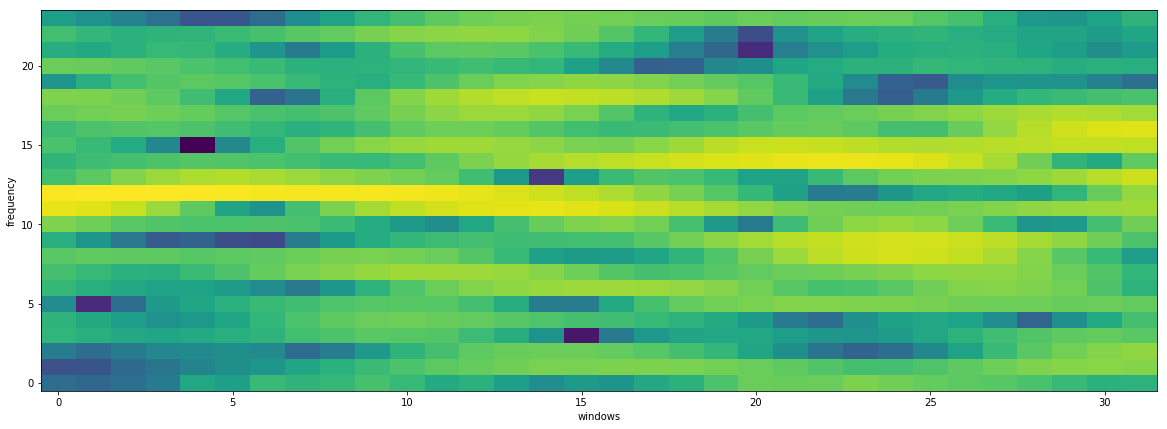

In [11]:
fig = plt.figure(figsize=(20,7))
plt.imshow(n1[0],aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('windows')
fig.axes[0].set_ylabel('frequency')

# DNN SPINE paper

In [ ]:
todo